<a href="https://colab.research.google.com/github/Amarantine-xiv/Amas-FF14-Combat-Sim/blob/main/CoreSimulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2024 Amarantine Falena

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**Instructions for use**: From the Github, click "Open in Colab". You may need to log into Google's Colab, a Jupyter Python notebook service with free access. Hit File > Save a Copy in Drive (you only have to do this once).

To input a rotation, the template "My 7.0 Rotation" has been provided below. Fill that in with the class/stats you want, and the skills and party buffs/debuffs of choice.

To run the simulator, hit Runtime > Run all (or Ctrl+F9) to re-run and load everything (this is fast), or 2) just run the cells you want and the simmed results will print out. The template has an example and further instructions. Happy simming!

In [1]:
GAME_VERSION="7.0" #Or use "6.55" if you want current patch.

In [2]:
#@title Get ama_xiv_combat_sim, and setup the simulation environment
!pip install --index-url https://pypi.org/simple/ --no-deps ama-xiv-combat-sim>=2024.6.7.1

import ama_xiv_combat_sim
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time

from ama_xiv_combat_sim.example_rotations.get_example_rotations import get_example_rotations
from ama_xiv_combat_sim.kill_time_estimator.kill_time_estimator import KillTimeEstimator
from ama_xiv_combat_sim.rotation_analysis.rotation_analysis_utils import RotationAnalysisUtils
from ama_xiv_combat_sim.simulator.skills import create_skill_library, SkillModifier
from ama_xiv_combat_sim.simulator.stats import Stats
from ama_xiv_combat_sim.simulator.damage_simulator import DamageSimulator
from ama_xiv_combat_sim.simulator.rotation_import_utils.csv_utils import CSVUtils
from ama_xiv_combat_sim.simulator.timeline_builders.damage_builder import DamageBuilder
from ama_xiv_combat_sim.simulator.timeline_builders.rotation_builder import RotationBuilder

SKILL_LIBRARY = create_skill_library(GAME_VERSION)
# initial setup
if 'ROTATION_LIBRARY' not in locals():
  ROTATION_LIBRARY = get_example_rotations(SKILL_LIBRARY)
  for v in ROTATION_LIBRARY.values():
    v.get_skill_timing()

class DisplayUtils:
  PERCENTILES_TO_USE = [1,5,25,50,75,95,99]
  COLOURS_TO_USE = ['black', 'dimgray', 'g', 'b', (0.36, 0.28, 0.55), (1,0.5,0), (1,0.0,0.5)]

  @staticmethod
  def print_button_press_timings(rb):
    print('---Times (in s) when skills get used:---')
    for tmp in rb.get_button_press_timing():
      print('{:>8}: {:>22}'.format(tmp[0]/1000.0, tmp[1]))
    print('\n')

  @staticmethod
  def print_damage_applications(per_skill_damage):
    print('---Times (in s) when damage lands:---')
    for sk in per_skill_damage:
      print('time: {:>8}, name: {:>22}, expected_damage: {:9.2f}, potency: {:4n}, skill modifier: {:>22}, damage variance: {:6.2f}'.format(sk.application_time/1000.0,
                                                                                                                                           sk.skill_name,
                                                                                                                                           sk.expected_damage,
                                                                                                                                           sk.potency,
                                                                                                                                           ", ".join(sk.skill_modifier_condition),
                                                                                                                                           sk.standard_deviation))

  @staticmethod
  def print_damage_details(per_skill_damage, damage_ranges, status_effect_names_only=True):
    print('---Damage ranges and expectation:---')
    for i in range(0, len(damage_ranges)):
      sk = per_skill_damage[i]
      print('{:5n}: {:<22}, Potency: {:4n}, Modifier: "{}". '.format( sk.application_time/1000.0, damage_ranges[i][0], sk.potency, ", ".join(sk.skill_modifier_condition)))
      buffs, debuffs = sk.status_effects[0], sk.status_effects[1]
      if status_effect_names_only:
         print('  Buffs: ||{}||'.format(", ".join(buffs.status_effects)))
         print('  DeBuffs: ||{}||'.format(", ".join(debuffs.status_effects)))
      else:
        print('  Buffs: ||{:>22}||  crit: {:3.2f}, dh: {:3.2f}, damage_mult: {:3.2f}, guaranteed crit/dh: {}/{}:'.format(", ".join(buffs.status_effects),
                                                                                                                         buffs.crit_rate_add,
                                                                                                                         buffs.dh_rate_add,
                                                                                                                         buffs.damage_mult,
                                                                                                                         buffs.guaranteed_crit,
                                                                                                                         buffs.guaranteed_dh))
        print('  Debuffs: ||{:>22}||  crit: {:3.2f}, dh: {:3.2f}, damage_mult: {:3.2f}, guaranteed crit/dh: {}/{}:'.format(", ".join(debuffs.status_effects),
                                                                                                                           debuffs.crit_rate_add,
                                                                                                                           debuffs.dh_rate_add,
                                                                                                                           debuffs.damage_mult,
                                                                                                                           debuffs.guaranteed_crit,
                                                                                                                           debuffs.guaranteed_dh))
      for tmp in damage_ranges[i][1:]:
        print('   {:>14} ({:5.1f}%). expected_damage: {:9.2f},   [low, high]: [{}, {}]'.format(tmp[0], 100*tmp[3], (tmp[1]+tmp[2])/2, tmp[1], tmp[2]))

  @staticmethod
  def print_results(total_damage, title='Average Damage'):
    percs = np.percentile(total_damage, DisplayUtils.PERCENTILES_TO_USE)
    print('{}: {mean:.2f}'.format(title, mean=np.mean(total_damage)))
    for i in range(0, len(DisplayUtils.PERCENTILES_TO_USE)):
      print('Percentile {}: {percs:.2f}'.format(DisplayUtils.PERCENTILES_TO_USE[i], percs=percs[i]))
    print()

  @staticmethod
  def display_results(total_damage, xlabel='DPS', title=None, display_cumulative=True):
    percs = np.percentile(total_damage, DisplayUtils.PERCENTILES_TO_USE)

    try:
      count, bins_count = np.histogram(total_damage, bins=500)
    except ValueError:
      return

    plt.figure()
    pdf = count / sum(count)
    plt.plot(bins_count[1:], pdf)
    for i in range(len(percs)):
      plt.plot([percs[i], percs[i]], [0, max(pdf)], color=DisplayUtils.COLOURS_TO_USE[i])
    plt.ylabel('Probability')
    plt.xlabel(xlabel)
    if title is not None:
      plt.title(title)
    plt.show(block=False)

    if display_cumulative:
      plt.figure()
      plt.plot(bins_count[1:], np.cumsum(pdf))
      plt.ylabel('Cumulative Probability')
      plt.xlabel('{} <= Value'.format(xlabel))
      if title is not None:
        plt.title(title)
      plt.show(block=False)

  @staticmethod
  def display_damage_over_time(damage, t, window_length, title_prefix='Damage done'):
    RESOLUTION = 10
    x = np.asarray(range(int(min(t)), int(max(t)), RESOLUTION))
    res = np.zeros((len(x),1))
    t = np.asarray(t)
    damage = np.asarray(damage)

    for i in range(0,len(x)):
      time_to_use = x[i]
      idx = np.argwhere((t >= time_to_use) & (t <= time_to_use+window_length*1000))[:,0]
      res[i] = np.sum(damage[idx])

    plt.figure()
    plt.plot(x/1000, res)
    plt.title('{} in a time window of {}s'.format(title_prefix, window_length))
    plt.xlabel('Starting Time of Window')
    plt.ylabel('Average damage in time window')
    plt.show(block=False)
    return res

  @staticmethod
  def display_damage_snapshots_in_time_window(per_skill_damage, window_length):
    DisplayUtils.display_damage_over_time([float(x.expected_damage) for x in per_skill_damage],
                                          [float(x.snapshot_time) for x in per_skill_damage],
                                          window_length,
                                          title_prefix='Snapshotted Damage Done')


  @staticmethod
  def display_kill_time_estimates(kill_times):
    num_examples = len(kill_times)
    kill_time_success = list(filter(lambda x: x is not None, kill_times))
    num_kill_succeeded = len(kill_time_success)
    print('Num success: {}. Total: {}'.format(num_kill_succeeded, num_examples))

    if num_kill_succeeded == 0:
      print('Boss cannot be killed with given rotations')
      return

    count, bins_count = np.histogram(kill_time_success, bins=500)
    plt.figure()
    pdf = (num_kill_succeeded/num_examples) * count / sum(count)
    plt.plot(bins_count[1:], pdf)
    plt.title('Kill time')
    plt.ylabel('Probability')
    plt.xlabel('Time')

    plt.figure()
    plt.plot(bins_count[1:], np.cumsum(pdf))
    plt.title('Probability of killing boss at time <= T')
    plt.xlabel('Time=T')
    plt.ylabel('Probability')

#@title execute_rotation
def execute_rotation(rb, skill_library, num_samples=200000):
  stats = rb.get_stats()
  db = DamageBuilder(stats, skill_library)
  start = time.time()
  sim = DamageSimulator(stats, db.get_damage_instances(rb.get_skill_timing()), num_samples)
  end = time.time()
  print('Time taken: {}'.format(end-start))
  dps = sim.get_dps()
  damage = sim.get_raw_damage()
  per_skill_damage = sim.get_per_skill_damage(rb)
  damage_ranges = sim.get_damage_ranges()
  t = sim.get_damage_time()
  return dps, damage, per_skill_damage, damage_ranges, t

def execute_rotation_and_display_results(rotation_name, rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
  rotation_to_use= rotation_library[rotation_name]
  dps, damage, per_skill_damage, damage_ranges, t = execute_rotation(rotation_to_use, skill_library, num_samples=100000)

  print('Results: ')

  DisplayUtils.print_button_press_timings(rotation_to_use)
  DisplayUtils.print_damage_applications(per_skill_damage)
  DisplayUtils.print_damage_details(per_skill_damage, damage_ranges, status_effect_names_only=True)

  if len(per_skill_damage) > 0:
    DisplayUtils.display_damage_snapshots_in_time_window(per_skill_damage, window_length=15)
    DisplayUtils.display_results(dps, title='DPS over {} s'.format(per_skill_damage[-1].application_time/1000), display_cumulative=False)

  DisplayUtils.print_results(dps, title='Average DPS')
  DisplayUtils.print_results(damage, title='Average Damage')

  print('---Expected max damage over N runs---')
  for num_runs in [1,5,10,20,50,100]:
    print('{} Runs: {:.2f}'.format(num_runs, RotationAnalysisUtils.get_expected_max_in_k_runs(dps,num_runs, num_trials=10000)))

def add_to_rotation_library(rotation_name, rb, rotation_library):
  if rotation_name in rotation_library:
    print('Updating rotation \"{}\" in the rotation library.'.format(rotation_name))
  rotation_library[rotation_name] = rb



'Not in skill library: GNB/Rough Divide'
'Not in skill library: GNB/Rough Divide'
'Not in skill library: DRK/Plunge'
'Not in skill library: DRK/Plunge'
'Not in skill library: DRK/Plunge'
'Not in skill library: AST/Draw'
'Not in skill library: AST/Draw'
'Not in skill library: AST/Astrodyne'
'Not in skill library: SAM/Hakaze'
'Not in skill library: SAM/Hakaze'
'Not in skill library: DRG/Disembowel'
'Not in skill library: DRG/Dragon Sight'
'Not in skill library: DRG/Vorpal Thrust'
'Not in skill library: DRG/Spineshatter Dive'
'Not in skill library: DRG/Disembowel'
'Not in skill library: NIN/Mug'
'Not in skill library: NIN/Trick Attack'
'Not in skill library: BLM/Sharpcast'
'Not in skill library: BLM/Sharpcast'
'Not in skill library: SMN/Fester'
'Not in skill library: SMN/Fester'


In [3]:

#@title Example of adding a 7.0 Rotation

# Note: this works for 6.55 rotations too, you just need to set
# GAME_VERSION="6.55" at the top.

def add_my_rotation(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY):
    # input your stats here (TODO: etro and xivgear links).
    # these stats include food only; 5% party buffs are added automatically during the sim.
    stats = Stats(
        wd=132,
        weapon_delay=3.36,
        main_stat=3330,
        det_stat=2182,
        crit_stat=2596,
        dh_stat=940,
        speed_stat=400,
        tenacity=601,
        job_class="WAR",
        version=GAME_VERSION
    )

    rb = RotationBuilder(
        stats,
        skill_library,
        ignore_trailing_dots=True,
        enable_autos=True,
        snap_dots_to_server_tick_starting_at=0,
    )
    rotation_name = "My 7.0 Rotation"

    # Example of party buffs/debuffs.
    # This sim supports all buffs/debuffs up to Endwalker (Dawntrail coming soon).
    # Generally, just type in 1) the time the buff/debuff is used, 2) the name of
    # the name of the skill that triggers the buff/debuff as it appears on the
    # FF14 job site, and 3) the job class it belongs to. For skills that apply a
    # buff/debuff that also have damage, you may need to specify that you only
    # want to add the buff/debuff portion. Eg:
    #    rb.add(6.3, 'Dokumori', job_class='NIN', skill_modifier=SkillModifier(with_condition='Debuff Only'))
    rb.add(6.3, "Chain Stratagem", job_class="SCH")
    rb.add(7.1, "Battle Litany", job_class="DRG")
    rb.add(0.8, "Arcane Circle", job_class="RPR")
    rb.add(6.28, "Embolden", job_class="RDM")
    rb.add(
        6.3,
        "Dokumori",
        job_class="NIN",
        skill_modifier=SkillModifier(with_condition="Debuff Only"),
    )

    # Example of rotation of interest.
    # Generally, you just type in the name of the skill you want to use as it appears
    # on the FF14 job site. For certain special conditions (eg, no positional), you may have to use
    # the skill_modifier field to indicate the condition under which you're using the skill.
    # Example of SkillModifier:
    # For SAM:
    #    rb.add_next('Gekko', skill_modifier=SkillModifier(with_condition='No Positional'))
    # Will indicate that Gekko was used, but the positional was not hit. Note that
    # the sim will automatically track combos and conditions that can be inferred
    # from skill usage (eg, using Inner Release on WAR, Meikyo Shisui on SAM) that
    # result in changes to skills (guaranteed crit/dh for Inner Release,
    # automatically meeting combo requirements for Meikyo Shisui). Please see the
    # class SkillModifier and the corresponding class's skill library for
    # information on the conditionals.

    # In general, you just need to type in the names of the buttons you'd hit.
    rb.add_next("Tomahawk")
    rb.add_next("Infuriate")
    rb.add_next("Heavy Swing")
    rb.add_next("Maim")
    rb.add_next("Grade 8 Tincture")
    rb.add_next("Storm's Eye")
    rb.add_next("Inner Release")
    rb.add_next("Inner Chaos")
    rb.add_next("Upheaval")
    rb.add_next("Onslaught")
    rb.add_next("Primal Rend")
    rb.add_next("Inner Chaos")
    rb.add_next("Onslaught")
    rb.add_next("Fell Cleave")
    rb.add_next("Onslaught")
    rb.add_next("Fell Cleave")
    rb.add_next("Fell Cleave")
    rb.add_next("Heavy Swing")
    rb.add_next("Maim")
    rb.add_next("Storm's Path")
    rb.add_next("Fell Cleave")
    rb.add_next("Inner Chaos")
    # New 7.0 skills; I have no idea where they go
    # in the rotation, so here they are.
    rb.add_next("Primal Ruination")
    rb.add_next("Primal Wrath")

    add_to_rotation_library(rotation_name, rb, rotation_library)


add_my_rotation(ROTATION_LIBRARY, SKILL_LIBRARY)

In [4]:
#@title Example of adding a rotation from a CSV

# This is the same as add_my_rotation(...), but where the rotation is specified
# in a CSV file. For the example CSV file, please refer to:
# https://github.com/Amarantine-xiv/Amas-FF14-Combat-Sim/blob/main/my_rotation.csv
# If you'd like to create your own CSV files, feel free to! Follow the example
# in my_rotation.csv (see the link above). Note the names of the columns!!! To upload
# your CSV rotation file to this workspace, click the folder icon on the left <----
# then the upload icon (file with an up arrow). Navigate to your file, and select it.
# It should then be accessible in this workbook. You may overwrite the file at any time.
# If you prefer a Google Drive sheets example, you can use this one as template:
# https://docs.google.com/spreadsheets/d/1wvq7QDVic3SLZ5may3_1fNfOYF9vCufF04E4yDfSoI4.
# If using the Drive sheet, you will have to:
#   1) download it (File->Download->Comma-separated values (.csv)), and
#   2) upload the file to this workspace
#      i) Click the Folder icon on the left <--- in the sidebar.
#     ii) Click the file with the up arrow on it.
#    iii) Navigate to the file you downloaded, and click on that to upload to this workspace.
#   3) (Optional) Set the csv_filename and rotation_name entries to your uploaded file name, and name the rotation whatever you like.
#
# If you find this a hassle, let Amarantine know (on Discord or Github).
# Amarantine can enable reading directly from your Drive, though you would have
# to grant this notebook/app some permissions which can be scary, to be honest.
def add_my_rotation_from_CSV(rotation_library=ROTATION_LIBRARY, skill_library=SKILL_LIBRARY, csv_filename='', rotation_name= ''):
  stats = Stats(wd=132, weapon_delay=3.36, main_stat=3330, det_stat=2182, crit_stat=2596, dh_stat=940, speed_stat=400, tenacity=601, job_class = 'WAR', version=GAME_VERSION)
  rb = RotationBuilder(stats, SKILL_LIBRARY, ignore_trailing_dots=True, enable_autos=True, snap_dots_to_server_tick_starting_at=0)

  if not os.path.exists(csv_filename):
    print('File does not exist: {}. Make sure you are in the right directory and have the right file name (see the folder icon on the left <----).'.format(csv_filename))
  else:
    rb, _ = CSVUtils.populate_rotation_from_csv(rb, csv_filename)
  add_to_rotation_library(rotation_name, rb, rotation_library)

add_my_rotation_from_CSV(ROTATION_LIBRARY, SKILL_LIBRARY, csv_filename='my_rotation.csv', rotation_name='My CSV Rotation')


File does not exist: my_rotation.csv. Make sure you are in the right directory and have the right file name (see the folder icon on the left <----).


In [5]:
#@title Example code to view the rotations in the rotation library, and print out a given rotation.

# #Uncomment this if you want to see the current rotations in the library
# for k in ROTATION_LIBRARY.keys():
#   print(k)

# #Uncomment this if you want to see the buttons pressed for the given rotation.
# rotation_name_to_view = 'WAR 6.55'
# print('Rotation name: {}'.format(rotation_name_to_view))
# DisplayUtils.print_button_press_timings(ROTATION_LIBRARY[rotation_name_to_view])

Time taken: 0.73663330078125
Results: 
---Times (in s) when skills get used:---
  -0.713:               Tomahawk
  -0.063:              Infuriate
   0.087:          Arcane Circle
   1.787:            Heavy Swing
   4.287:                   Maim
   4.937:       Grade 8 Tincture
   5.567:               Embolden
   5.587:        Chain Stratagem
   5.587:               Dokumori
   6.387:          Battle Litany
   6.787:            Storm's Eye
   7.437:          Inner Release
   9.287:            Inner Chaos
   9.937:               Upheaval
  10.587:              Onslaught
  11.787:            Primal Rend
  14.287:            Inner Chaos
  14.937:              Onslaught
  16.787:            Fell Cleave
  17.437:              Onslaught
  19.287:            Fell Cleave
  21.787:            Fell Cleave
  24.287:            Heavy Swing
  26.787:                   Maim
  29.287:           Storm's Path
  31.787:            Fell Cleave
  34.287:            Inner Chaos
  36.787:       Primal Ruinat

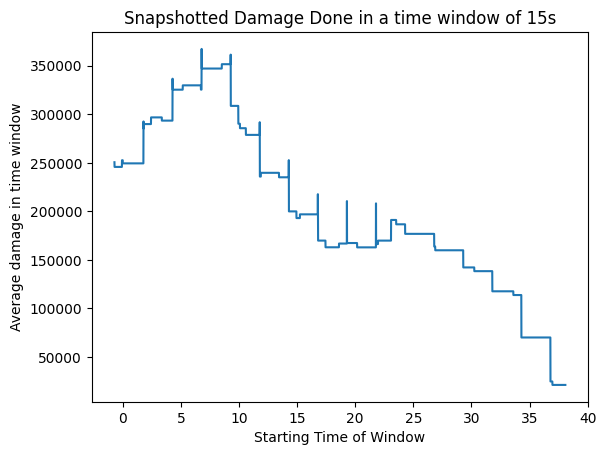

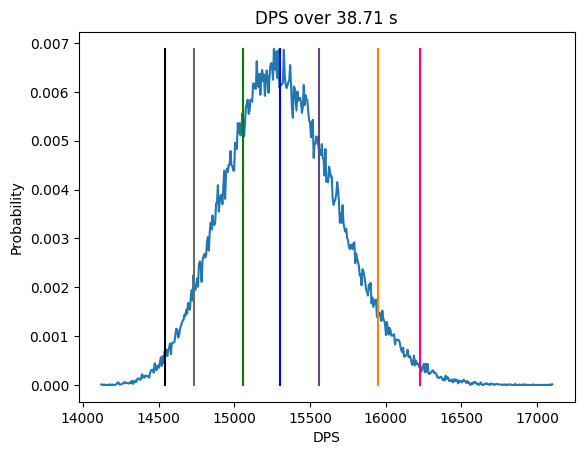

Average DPS: 15315.97
Percentile 1: 14539.76
Percentile 5: 14736.22
Percentile 25: 15057.12
Percentile 50: 15299.70
Percentile 75: 15559.60
Percentile 95: 15946.97
Percentile 99: 16224.52

Average Damage: 592881.28
Percentile 1: 562833.99
Percentile 5: 570439.00
Percentile 25: 582861.00
Percentile 50: 592251.50
Percentile 75: 602312.00
Percentile 95: 617307.05
Percentile 99: 628051.09

---Expected max damage over N runs---
1 Runs: 15318.37
5 Runs: 15753.43
10 Runs: 15904.09
20 Runs: 16034.24
50 Runs: 16192.19
100 Runs: 16301.96


In [6]:
#@title Example of executing a rotation (pre-set, CSV uploaded, or entered into the sim directly)

# You just need to specify the name of the rotation you want to use.

# This is a pre-set rotation. Uncomment to use.
rotation_to_use= 'My 7.0 Rotation'

# This is the rotation we filled in directly in 'Example of adding a rotation directly in the sim'. Uncomment to use.
# rotation_name= 'My Rotation'

# This is the rotation we provided from a CSV in 'Example of adding a rotation from a CSV'. Uncomment to use.
# rotation_name= 'My CSV Rotation'

execute_rotation_and_display_results(rotation_to_use)

Processing rotation 1/8
Processing rotation 2/8
Processing rotation 3/8
Processing rotation 4/8
Processing rotation 5/8
Processing rotation 6/8
Processing rotation 7/8
Processing rotation 8/8
Num success: 99912. Total: 100000


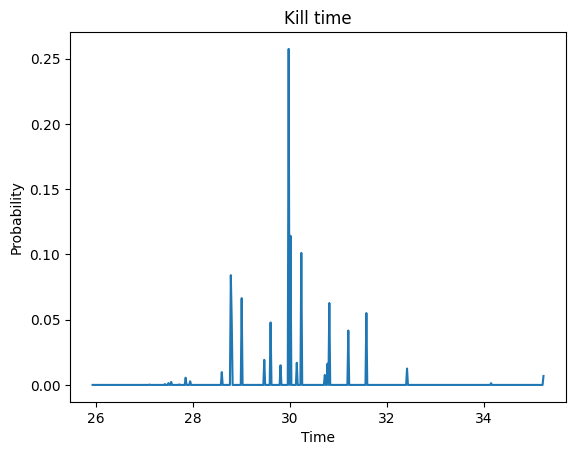

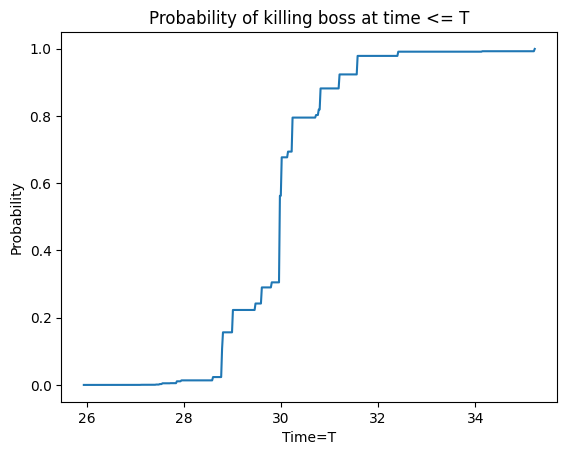

In [7]:
#@title Example of estimating kill time
boss_hp=3700000
kte = KillTimeEstimator(boss_hp=boss_hp)

# The rotations to load in. Note that these could also be rotations you upload
# from CSV files. See "Example of adding a rotation from a CSV" for how to
# upload your own CSV rotations and name them. You would use those rotation
# names below.
kte.add_rotation(ROTATION_LIBRARY['WAR 6.55 Party Buffs'])
kte.add_rotation(ROTATION_LIBRARY['DRK 6.55'])
kte.add_rotation(ROTATION_LIBRARY['SCH 6.55'])
kte.add_rotation(ROTATION_LIBRARY['WHM 6.55'])
kte.add_rotation(ROTATION_LIBRARY['RPR 6.55, Early Gluttony'])
kte.add_rotation(ROTATION_LIBRARY['SMN 6.55 Fast Garuda'])
kte.add_rotation(ROTATION_LIBRARY['MCH 6.55 Delayed Tools (Extended)'])

# Copy the rotation because we're about to change (you don't need to do
# this if you're building the rotation specifically for this kill time
# estimation). This also is an example of how to add in LB damage (you will need
# to specify how much damage your LB will do, since it depends on ilvl info the
# sim doesn't have).
sam_rotation = copy.deepcopy(ROTATION_LIBRARY['SAM 6.55, 2.15 gcd'])
sam_rotation.add(25, 'LB 3', skill_modifier=SkillModifier(with_condition='Mean Damage: 10000'))
# Times are close, just for the sake of example of how to specify LB damage and type.
sam_rotation.add(26, 'LB 1', skill_modifier=SkillModifier(with_condition='Exact Damage: 5000'))
kte.add_rotation(sam_rotation)

kill_times, _, _ = kte.estimate_kill_time(num_samples=100000)
DisplayUtils.display_kill_time_estimates(kill_times)